<a href="https://colab.research.google.com/github/sunandhini96/School_of_AI-Assignment_6/blob/main/train_net2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/sunandhini96/School_of_AI-Assignment_6.git

Cloning into 'School_of_AI-Assignment_6'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 28 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), 78.03 KiB | 6.50 MiB/s, done.


In [3]:
cd /content/School_of_AI-Assignment_6/

/content/School_of_AI-Assignment_6


In [4]:
ls

model.py  README.md  train_test.ipynb


In [5]:
from model import *

In [6]:
%matplotlib inline

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np

In [8]:
mean=(0.5, 0.5, 0.5)
std=(0.5, 0.5, 0.5)
def train_transform_function(mean,std):
  train_transform = A.Compose([A.HorizontalFlip(p=1),
                                       A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,rotate_limit=15,value=0),
                                       A.CoarseDropout(max_holes=1,max_height=16,  min_height=16, fill_value=mean, mask_fill_value = None),
                                        A.Normalize(mean,std),
                                       ToTensorV2()
                                       ])
  return lambda img:train_transform(image=np.array(img))["image"]

In [9]:
SEED = 4

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    # Train Phase transformations
                                          #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),


# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std)
                                       ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform_function(mean,std))
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=20, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=10)

# train dataloader
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)
# test dataloader
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([20, 3, 32, 32])


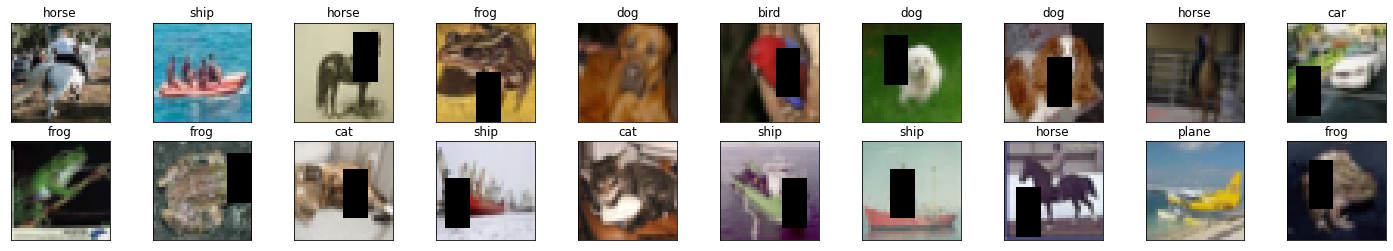

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
   
    plt.imshow(np.transpose(img, (1, 2, 0)))
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
images=images.numpy()
# show images
fig=plt.figure(figsize=(25,4))
#display 50 images
# Display 20 images
for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      imshow(images[idx])
      ax.set_title(classes[labels[idx]])







In [11]:
from model import Net2

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net2().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
            Conv2d-2           [-1, 32, 30, 30]           4,608
              ReLU-3           [-1, 32, 30, 30]               0
       BatchNorm2d-4           [-1, 32, 30, 30]              64
           Dropout-5           [-1, 32, 30, 30]               0
            Conv2d-6           [-1, 32, 13, 13]             288
            Conv2d-7           [-1, 64, 13, 13]           2,048
depthwise_separable_conv-8           [-1, 64, 13, 13]               0
              ReLU-9           [-1, 64, 13, 13]               0
      BatchNorm2d-10           [-1, 64, 13, 13]             128
          Dropout-11           [-1, 64, 13, 13]               0
           Conv2d-12           [-1, 64, 13, 13]          

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss=0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    #train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
  processed += len(data)
  train_loss/=len(train_loader.dataset)
  train_losses.append(train_loss)
  print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    train_loss, correct, len(train_loader.dataset),
    100. * correct / len(train_loader.dataset)))
  pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/len(train_loader.dataset))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


In [18]:
from torch.optim.lr_scheduler import StepLR

model = model
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 60
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    scheduler.step()
    test(model, device, testloader)

EPOCH: 0


100%|██████████| 2500/2500 [00:26<00:00, 95.74it/s] 



Train set: Average loss: 0.0729, Accuracy: 23660/50000 (47.32%)


Test set: Average loss: 0.0603, Accuracy: 5662/10000 (56.62%)

EPOCH: 1


100%|██████████| 2500/2500 [00:26<00:00, 96.13it/s] 



Train set: Average loss: 0.0651, Accuracy: 26736/50000 (53.47%)


Test set: Average loss: 0.0530, Accuracy: 6207/10000 (62.07%)

EPOCH: 2


100%|██████████| 2500/2500 [00:25<00:00, 97.09it/s]



Train set: Average loss: 0.0599, Accuracy: 28653/50000 (57.31%)


Test set: Average loss: 0.0486, Accuracy: 6559/10000 (65.59%)

EPOCH: 3


100%|██████████| 2500/2500 [00:26<00:00, 96.08it/s] 



Train set: Average loss: 0.0560, Accuracy: 30162/50000 (60.32%)


Test set: Average loss: 0.0457, Accuracy: 6791/10000 (67.91%)

EPOCH: 4


100%|██████████| 2500/2500 [00:25<00:00, 96.27it/s]



Train set: Average loss: 0.0530, Accuracy: 31265/50000 (62.53%)


Test set: Average loss: 0.0422, Accuracy: 7062/10000 (70.62%)

EPOCH: 5


100%|██████████| 2500/2500 [00:26<00:00, 95.87it/s]



Train set: Average loss: 0.0505, Accuracy: 32211/50000 (64.42%)


Test set: Average loss: 0.0403, Accuracy: 7200/10000 (72.00%)

EPOCH: 6


100%|██████████| 2500/2500 [00:25<00:00, 96.25it/s]



Train set: Average loss: 0.0459, Accuracy: 33929/50000 (67.86%)


Test set: Average loss: 0.0367, Accuracy: 7444/10000 (74.44%)

EPOCH: 7


100%|██████████| 2500/2500 [00:25<00:00, 96.95it/s]



Train set: Average loss: 0.0450, Accuracy: 34328/50000 (68.66%)


Test set: Average loss: 0.0365, Accuracy: 7447/10000 (74.47%)

EPOCH: 8


100%|██████████| 2500/2500 [00:25<00:00, 96.93it/s]



Train set: Average loss: 0.0445, Accuracy: 34496/50000 (68.99%)


Test set: Average loss: 0.0370, Accuracy: 7386/10000 (73.86%)

EPOCH: 9


100%|██████████| 2500/2500 [00:25<00:00, 98.63it/s] 



Train set: Average loss: 0.0440, Accuracy: 34602/50000 (69.20%)


Test set: Average loss: 0.0361, Accuracy: 7448/10000 (74.48%)

EPOCH: 10


100%|██████████| 2500/2500 [00:25<00:00, 98.31it/s] 



Train set: Average loss: 0.0438, Accuracy: 34684/50000 (69.37%)


Test set: Average loss: 0.0354, Accuracy: 7535/10000 (75.35%)

EPOCH: 11


100%|██████████| 2500/2500 [00:25<00:00, 97.57it/s]



Train set: Average loss: 0.0433, Accuracy: 34820/50000 (69.64%)


Test set: Average loss: 0.0357, Accuracy: 7515/10000 (75.15%)

EPOCH: 12


100%|██████████| 2500/2500 [00:25<00:00, 98.59it/s] 



Train set: Average loss: 0.0426, Accuracy: 35089/50000 (70.18%)


Test set: Average loss: 0.0355, Accuracy: 7524/10000 (75.24%)

EPOCH: 13


100%|██████████| 2500/2500 [00:25<00:00, 97.78it/s] 



Train set: Average loss: 0.0427, Accuracy: 34977/50000 (69.95%)


Test set: Average loss: 0.0352, Accuracy: 7551/10000 (75.51%)

EPOCH: 14


100%|██████████| 2500/2500 [00:25<00:00, 96.52it/s]



Train set: Average loss: 0.0425, Accuracy: 35219/50000 (70.44%)


Test set: Average loss: 0.0356, Accuracy: 7532/10000 (75.32%)

EPOCH: 15


100%|██████████| 2500/2500 [00:25<00:00, 98.74it/s] 



Train set: Average loss: 0.0428, Accuracy: 35026/50000 (70.05%)


Test set: Average loss: 0.0354, Accuracy: 7524/10000 (75.24%)

EPOCH: 16


100%|██████████| 2500/2500 [00:25<00:00, 97.34it/s] 



Train set: Average loss: 0.0426, Accuracy: 35053/50000 (70.11%)


Test set: Average loss: 0.0349, Accuracy: 7546/10000 (75.46%)

EPOCH: 17


100%|██████████| 2500/2500 [00:25<00:00, 96.93it/s]



Train set: Average loss: 0.0426, Accuracy: 35107/50000 (70.21%)


Test set: Average loss: 0.0358, Accuracy: 7489/10000 (74.89%)

EPOCH: 18


100%|██████████| 2500/2500 [00:25<00:00, 97.60it/s] 



Train set: Average loss: 0.0427, Accuracy: 35090/50000 (70.18%)


Test set: Average loss: 0.0353, Accuracy: 7543/10000 (75.43%)

EPOCH: 19


100%|██████████| 2500/2500 [00:25<00:00, 98.67it/s] 



Train set: Average loss: 0.0424, Accuracy: 35090/50000 (70.18%)


Test set: Average loss: 0.0358, Accuracy: 7495/10000 (74.95%)

EPOCH: 20


100%|██████████| 2500/2500 [00:25<00:00, 97.86it/s] 



Train set: Average loss: 0.0424, Accuracy: 35145/50000 (70.29%)


Test set: Average loss: 0.0351, Accuracy: 7544/10000 (75.44%)

EPOCH: 21


100%|██████████| 2500/2500 [00:25<00:00, 99.56it/s]



Train set: Average loss: 0.0425, Accuracy: 35257/50000 (70.51%)


Test set: Average loss: 0.0355, Accuracy: 7513/10000 (75.13%)

EPOCH: 22


100%|██████████| 2500/2500 [00:25<00:00, 97.94it/s] 



Train set: Average loss: 0.0427, Accuracy: 35078/50000 (70.16%)


Test set: Average loss: 0.0347, Accuracy: 7568/10000 (75.68%)

EPOCH: 23


100%|██████████| 2500/2500 [00:25<00:00, 98.21it/s] 



Train set: Average loss: 0.0424, Accuracy: 35186/50000 (70.37%)


Test set: Average loss: 0.0347, Accuracy: 7576/10000 (75.76%)

EPOCH: 24


100%|██████████| 2500/2500 [00:25<00:00, 98.82it/s]



Train set: Average loss: 0.0422, Accuracy: 35232/50000 (70.46%)


Test set: Average loss: 0.0355, Accuracy: 7515/10000 (75.15%)

EPOCH: 25


100%|██████████| 2500/2500 [00:25<00:00, 98.37it/s] 



Train set: Average loss: 0.0423, Accuracy: 35251/50000 (70.50%)


Test set: Average loss: 0.0354, Accuracy: 7519/10000 (75.19%)

EPOCH: 26


100%|██████████| 2500/2500 [00:25<00:00, 97.62it/s] 



Train set: Average loss: 0.0426, Accuracy: 35142/50000 (70.28%)


Test set: Average loss: 0.0350, Accuracy: 7562/10000 (75.62%)

EPOCH: 27


100%|██████████| 2500/2500 [00:25<00:00, 98.92it/s] 



Train set: Average loss: 0.0425, Accuracy: 35111/50000 (70.22%)


Test set: Average loss: 0.0350, Accuracy: 7541/10000 (75.41%)

EPOCH: 28


100%|██████████| 2500/2500 [00:25<00:00, 98.37it/s] 



Train set: Average loss: 0.0424, Accuracy: 35196/50000 (70.39%)


Test set: Average loss: 0.0348, Accuracy: 7557/10000 (75.57%)

EPOCH: 29


100%|██████████| 2500/2500 [00:25<00:00, 98.40it/s] 



Train set: Average loss: 0.0423, Accuracy: 35157/50000 (70.31%)


Test set: Average loss: 0.0351, Accuracy: 7542/10000 (75.42%)

EPOCH: 30


100%|██████████| 2500/2500 [00:25<00:00, 98.27it/s] 



Train set: Average loss: 0.0424, Accuracy: 35237/50000 (70.47%)


Test set: Average loss: 0.0351, Accuracy: 7522/10000 (75.22%)

EPOCH: 31


100%|██████████| 2500/2500 [00:25<00:00, 98.28it/s]



Train set: Average loss: 0.0425, Accuracy: 35219/50000 (70.44%)


Test set: Average loss: 0.0358, Accuracy: 7487/10000 (74.87%)

EPOCH: 32


100%|██████████| 2500/2500 [00:25<00:00, 97.51it/s] 



Train set: Average loss: 0.0425, Accuracy: 35159/50000 (70.32%)


Test set: Average loss: 0.0354, Accuracy: 7529/10000 (75.29%)

EPOCH: 33


100%|██████████| 2500/2500 [00:25<00:00, 97.93it/s] 



Train set: Average loss: 0.0424, Accuracy: 35201/50000 (70.40%)


Test set: Average loss: 0.0354, Accuracy: 7524/10000 (75.24%)

EPOCH: 34


100%|██████████| 2500/2500 [00:25<00:00, 98.32it/s]



Train set: Average loss: 0.0424, Accuracy: 35233/50000 (70.47%)


Test set: Average loss: 0.0357, Accuracy: 7495/10000 (74.95%)

EPOCH: 35


100%|██████████| 2500/2500 [00:25<00:00, 97.27it/s] 



Train set: Average loss: 0.0423, Accuracy: 35230/50000 (70.46%)


Test set: Average loss: 0.0353, Accuracy: 7551/10000 (75.51%)

EPOCH: 36


100%|██████████| 2500/2500 [00:25<00:00, 98.67it/s]



Train set: Average loss: 0.0423, Accuracy: 35139/50000 (70.28%)


Test set: Average loss: 0.0350, Accuracy: 7548/10000 (75.48%)

EPOCH: 37


100%|██████████| 2500/2500 [00:25<00:00, 97.03it/s]



Train set: Average loss: 0.0426, Accuracy: 35069/50000 (70.14%)


Test set: Average loss: 0.0353, Accuracy: 7525/10000 (75.25%)

EPOCH: 38


100%|██████████| 2500/2500 [00:25<00:00, 99.07it/s]



Train set: Average loss: 0.0425, Accuracy: 35148/50000 (70.30%)


Test set: Average loss: 0.0352, Accuracy: 7526/10000 (75.26%)

EPOCH: 39


100%|██████████| 2500/2500 [00:25<00:00, 98.82it/s]



Train set: Average loss: 0.0420, Accuracy: 35251/50000 (70.50%)


Test set: Average loss: 0.0353, Accuracy: 7513/10000 (75.13%)

EPOCH: 40


100%|██████████| 2500/2500 [00:25<00:00, 99.03it/s] 



Train set: Average loss: 0.0425, Accuracy: 35074/50000 (70.15%)


Test set: Average loss: 0.0355, Accuracy: 7514/10000 (75.14%)

EPOCH: 41


100%|██████████| 2500/2500 [00:25<00:00, 98.31it/s]



Train set: Average loss: 0.0425, Accuracy: 35084/50000 (70.17%)


Test set: Average loss: 0.0356, Accuracy: 7532/10000 (75.32%)

EPOCH: 42


100%|██████████| 2500/2500 [00:24<00:00, 100.16it/s]



Train set: Average loss: 0.0426, Accuracy: 35143/50000 (70.29%)


Test set: Average loss: 0.0350, Accuracy: 7531/10000 (75.31%)

EPOCH: 43


100%|██████████| 2500/2500 [00:25<00:00, 97.37it/s] 



Train set: Average loss: 0.0423, Accuracy: 35242/50000 (70.48%)


Test set: Average loss: 0.0356, Accuracy: 7503/10000 (75.03%)

EPOCH: 44


100%|██████████| 2500/2500 [00:26<00:00, 96.08it/s]



Train set: Average loss: 0.0424, Accuracy: 35307/50000 (70.61%)


Test set: Average loss: 0.0355, Accuracy: 7527/10000 (75.27%)

EPOCH: 45


100%|██████████| 2500/2500 [00:25<00:00, 96.18it/s] 



Train set: Average loss: 0.0424, Accuracy: 35245/50000 (70.49%)


Test set: Average loss: 0.0361, Accuracy: 7480/10000 (74.80%)

EPOCH: 46


100%|██████████| 2500/2500 [00:25<00:00, 99.08it/s] 



Train set: Average loss: 0.0423, Accuracy: 35161/50000 (70.32%)


Test set: Average loss: 0.0354, Accuracy: 7532/10000 (75.32%)

EPOCH: 47


100%|██████████| 2500/2500 [00:25<00:00, 97.72it/s]



Train set: Average loss: 0.0423, Accuracy: 35265/50000 (70.53%)


Test set: Average loss: 0.0351, Accuracy: 7525/10000 (75.25%)

EPOCH: 48


100%|██████████| 2500/2500 [00:25<00:00, 98.14it/s] 



Train set: Average loss: 0.0424, Accuracy: 35195/50000 (70.39%)


Test set: Average loss: 0.0354, Accuracy: 7516/10000 (75.16%)

EPOCH: 49


100%|██████████| 2500/2500 [00:25<00:00, 98.32it/s] 



Train set: Average loss: 0.0422, Accuracy: 35260/50000 (70.52%)


Test set: Average loss: 0.0348, Accuracy: 7559/10000 (75.59%)

EPOCH: 50


100%|██████████| 2500/2500 [00:25<00:00, 98.91it/s] 



Train set: Average loss: 0.0425, Accuracy: 35038/50000 (70.08%)


Test set: Average loss: 0.0349, Accuracy: 7559/10000 (75.59%)

EPOCH: 51


100%|██████████| 2500/2500 [00:25<00:00, 97.36it/s]



Train set: Average loss: 0.0424, Accuracy: 35177/50000 (70.35%)


Test set: Average loss: 0.0350, Accuracy: 7555/10000 (75.55%)

EPOCH: 52


100%|██████████| 2500/2500 [00:25<00:00, 98.27it/s] 



Train set: Average loss: 0.0424, Accuracy: 35094/50000 (70.19%)


Test set: Average loss: 0.0348, Accuracy: 7569/10000 (75.69%)

EPOCH: 53


100%|██████████| 2500/2500 [00:25<00:00, 99.07it/s] 



Train set: Average loss: 0.0421, Accuracy: 35349/50000 (70.70%)


Test set: Average loss: 0.0358, Accuracy: 7505/10000 (75.05%)

EPOCH: 54


100%|██████████| 2500/2500 [00:25<00:00, 96.21it/s]



Train set: Average loss: 0.0424, Accuracy: 35159/50000 (70.32%)


Test set: Average loss: 0.0351, Accuracy: 7536/10000 (75.36%)

EPOCH: 55


100%|██████████| 2500/2500 [00:25<00:00, 99.42it/s]



Train set: Average loss: 0.0422, Accuracy: 35289/50000 (70.58%)


Test set: Average loss: 0.0352, Accuracy: 7531/10000 (75.31%)

EPOCH: 56


100%|██████████| 2500/2500 [00:25<00:00, 98.48it/s] 



Train set: Average loss: 0.0423, Accuracy: 35169/50000 (70.34%)


Test set: Average loss: 0.0352, Accuracy: 7536/10000 (75.36%)

EPOCH: 57


100%|██████████| 2500/2500 [00:25<00:00, 98.04it/s] 



Train set: Average loss: 0.0423, Accuracy: 35258/50000 (70.52%)


Test set: Average loss: 0.0352, Accuracy: 7517/10000 (75.17%)

EPOCH: 58


100%|██████████| 2500/2500 [00:26<00:00, 95.61it/s] 



Train set: Average loss: 0.0424, Accuracy: 35167/50000 (70.33%)


Test set: Average loss: 0.0349, Accuracy: 7555/10000 (75.55%)

EPOCH: 59


100%|██████████| 2500/2500 [00:26<00:00, 95.98it/s] 



Train set: Average loss: 0.0426, Accuracy: 35022/50000 (70.04%)


Test set: Average loss: 0.0348, Accuracy: 7559/10000 (75.59%)



Text(0.5, 1.0, 'Test Accuracy')

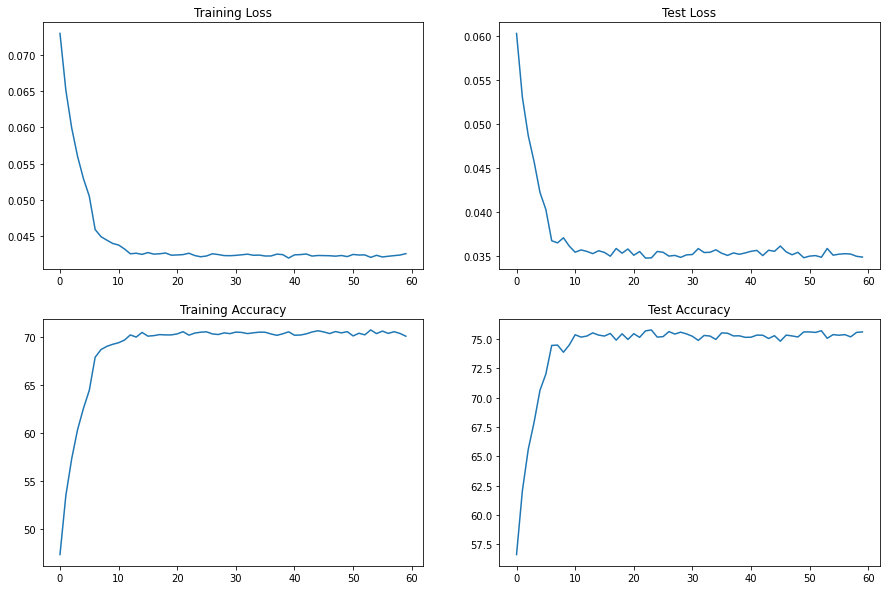

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
#t=[t.cpu().item() for t in train_losses]
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")